In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('../Loan-Prediction/train_data.csv')

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# Insights: 

1. LoanAmount has 22 missing values 
2. Loan_Amount_Term has 14 missing values 
3. Credit_History has 50 missing values

In [5]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

# Distribution Analysis 

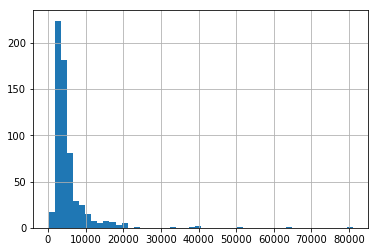

In [6]:
df['ApplicantIncome'].hist(bins=50)

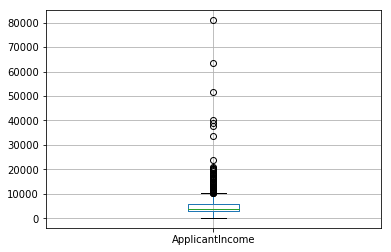

In [7]:
df.boxplot(column='ApplicantIncome')

The above boxplot shows the presence of a lot of outliers. This can be attributed to different education levels. Let's segregate them by Education.

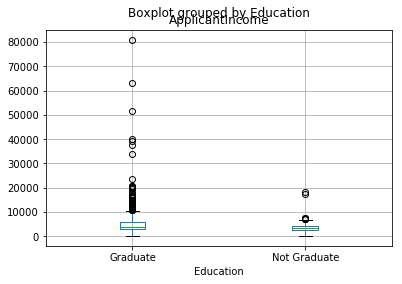

In [8]:
df.boxplot(column='ApplicantIncome', by='Education')

The mean amount for both Graduate and Non graduate students is the same. But there are many outliers in Graduate applicants. 

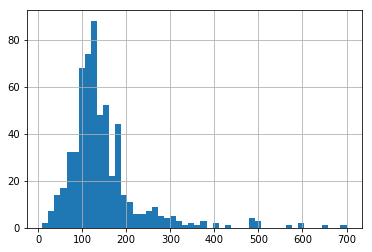

In [9]:
df['LoanAmount'].hist(bins=50)

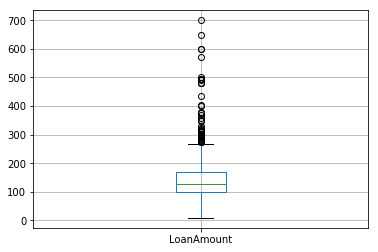

In [10]:
df.boxplot(column='LoanAmount')

Again LoanAmount has many outliers. 

## Categorical variable analysis 

In [11]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status', index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1, 'N':0}).mean())
print 'Frequency Table for Credit History'
print temp1

print '\n Probability of getting loan for each Credit History class:'
print temp2

Frequency Table for Credit History
0.0     89
1.0    475
Name: Credit_History, dtype: int64

 Probability of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)

This shows that the chances of getting a loan are much higher if the applicant has a valid credit history. 

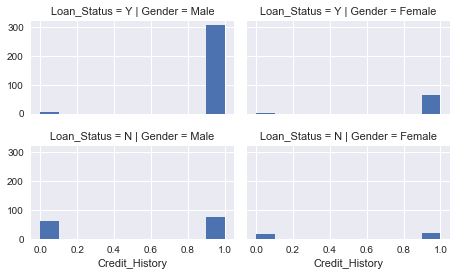

In [30]:
# Use of Seaborn

import seaborn as sns 
grid = sns.FacetGrid(df, col='Gender', row='Loan_Status',size=2, aspect=1.6)
grid.map(plt.hist, 'Credit_History', alpha=1, bins=10)
grid.add_legend();

We now have two basic classification algorithms here, one based on credit history, while other 2 on categorical variables (including gender). 

# Data Munging 

In [31]:
# Check missing values in the dataset 

df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## To fill missing values in LoanAmount

There are numerous methods to achieve that - the simplest method being replacement by mean, which can be done by the following code: 

In [ ]:
# df['LoanAmount].fillna(df['LoanAmount].mean(), inplace=True)

The other method is to predict the loan amount based on other variables. Here, whether a person is educated or self-employed can combine to give a good estimate of loan amount. 

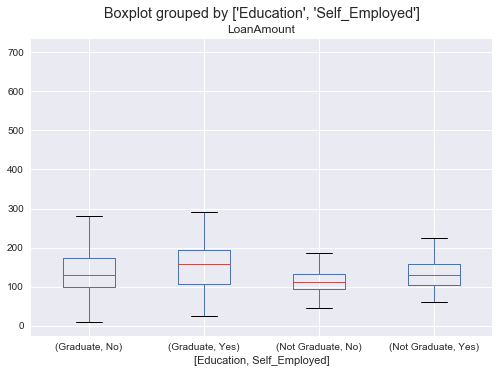

In [32]:
df.boxplot(column='LoanAmount', by=['Education', 'Self_Employed'])

We can see variations in the median of loan amount for each group and this can be impute the values. But first, we have to ensure that each of Self_Employed and Education variables should not have a missing values. 

In [34]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [35]:
# Due to higher probability of No, fill the remaining null values with No.
df['Self_Employed'].fillna('No', inplace=True)

Now, create a Pivot table which provides us median values for all groups of unique values of Self_Employed and Education features. 

In [39]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [40]:
# Define function to return value of this pivot_table
def fage(x):
    return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [41]:
df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Handling the outliers in LoanAmount and ApplicantIncome

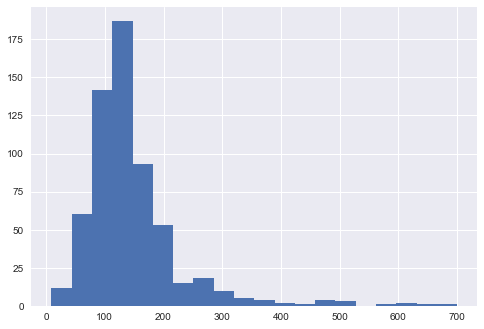

In [42]:
df['LoanAmount'].hist(bins=20)

As we can see there are many outliers in the above graph. Since it is practically possible, instead of treating them as outliers, let's try a log transformation to nullify their effect. 

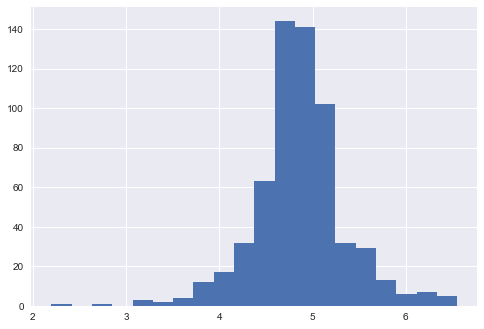

In [43]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided. 

Coming to ApplicantIncome, one intuition can be that some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both incomes as total income and take a log transformation of the same. 

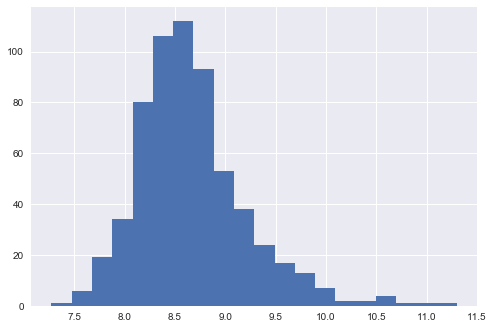

In [44]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20)